In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from bs4 import BeautifulSoup
import requests
import csv

# 1. Scrapping data

In [997]:

headers = ({'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})

prices_list = []
location_list = []
sq_mt_list = []
bedroom_list = []
bathroom_list = []
    
for i in range(1,7): # After page 7 there is a slight change in the  html code
    
    website = "https://www.pisos.com/alquiler/pisos-madrid_capital_zona_urbana/{}".format(str(i))
    source = requests.get(website, headers=headers).text
    html_soup = BeautifulSoup(source, 'lxml')
    house_containers = html_soup.find_all('div', class_="information exclusivo")
    
    
    prices = html_soup.find_all('div', class_="price")  # We can get the list of all 30 accomodation prices
    location = html_soup.find_all('div', class_="location")
    characteristics = html_soup.find_all('div', class_="characteristics")

    for j in range(len(house_containers)):
        prices_list.append(prices[j].text.strip())
        location_list.append(location[j].text.strip())
        sq_mt_list.append(characteristics[j].div.text.strip())
        bedroom_list.append(characteristics[j].div.find_next('div').text.strip())
        bathroom_list.append(characteristics[j].div.find_next('div').find_next('div').text.strip())

for i in range(7,101):
    try:
        website = "https://www.pisos.com/alquiler/pisos-madrid_capital_zona_urbana/{}".format(str(i))
        source = requests.get(website, headers=headers).text
        html_soup = BeautifulSoup(source, 'lxml')
        house_containers = html_soup.find_all('div', class_="information")

        prices = html_soup.find_all('div', class_="price")  # We can get the list of all 30 accomodation prices
        location = html_soup.find_all('div', class_="location")
        characteristics = html_soup.find_all('div', class_="characteristics")


        for j in range(len(house_containers)):
            prices_list.append(prices[j].text.strip())
            location_list.append(location[j].text.strip())
            sq_mt_list.append(characteristics[j].div.text.strip())
            bedroom_list.append(characteristics[j].div.find_next('div').text.strip())
            bathroom_list.append(characteristics[j].div.find_next('div').find_next('div').text.strip())
            
    except IndexError:
        pass
        
house_features = (list(zip(prices_list, location_list, sq_mt_list, bedroom_list, bathroom_list)))

data = pd.DataFrame(house_features, columns =["rent_price", "location", "sq_mt", "bedroom_n", "bathroom_n"])

data.to_csv("Df_rent_madrid3.csv", index=False)

# 2. Data Cleaning

In [1011]:
df2 = pd.read_csv("Df_rent_madrid2.csv")

In [1012]:
df2.shape

(2953, 5)

In [1013]:
df = pd.read_csv("Df_rent_madrid.csv")

In [1014]:
df = pd.concat([df,df2], axis=0)

In [1015]:
pd.set_option("display.max_rows", 90)

In [1016]:
df.drop_duplicates(keep=False,inplace=True)

In [1017]:
df.shape

(4566, 5)

In [1018]:
df["rent_price"] = df["rent_price"].str.replace(".", "").str.replace(" €/mes", "")
df["sq_mt"] = df["sq_mt"].str.replace(".", "").str.replace(" m²", "")

In [1019]:
def str_to_int(item):
    try: 
        return int(item)
    except ValueError:
        return np.nan

In [1020]:
df["rent_price"] = df["rent_price"].apply(str_to_int)
df["sq_mt"] = df["sq_mt"].apply(str_to_int)
df["bedroom_n"] = df["bedroom_n"].apply(str_to_int)
df["bathroom_n"] = df["bathroom_n"].apply(str_to_int)

In [1021]:
df.dtypes

rent_price    float64
location       object
sq_mt         float64
bedroom_n     float64
bathroom_n    float64
dtype: object

In [1022]:
df.isna().sum()

rent_price      3
location        0
sq_mt           5
bedroom_n      28
bathroom_n    312
dtype: int64

In [1023]:
df_loc = df["location"]

In [1024]:
df_loc = df_loc.reset_index().drop("index", axis=1)

In [1025]:
df.drop("location", axis=1, inplace=True) # we need to remove the cat variables for the method below to work

In [1026]:
from sklearn.impute import SimpleImputer # we can use this method from sklearn to fill the nan values with the meadian of each attribute
imputer = SimpleImputer(strategy = "median")
imputer.fit(df)
imputer.statistics_
df = pd.DataFrame(imputer.transform(df), columns = ["rent_price", "sq_mt", "bedroom_n", "bathroom_n"])

In [1027]:
df.isna().sum()

rent_price    0
sq_mt         0
bedroom_n     0
bathroom_n    0
dtype: int64

In [1028]:
df

,rent_price,sq_mt,bedroom_n,bathroom_n
0,750.0,70.0,3.0,1.0
1,800.0,46.0,1.0,1.0
2,2000.0,123.0,3.0,2.0
3,1600.0,135.0,3.0,2.0
4,800.0,55.0,1.0,1.0
...,...,...,...,...
4561,1800.0,110.0,2.0,2.0
4562,975.0,60.0,2.0,1.0
4563,2800.0,180.0,4.0,2.0
4564,2400.0,72.0,2.0,2.0


In [1029]:
df = pd.concat([df, df_loc], axis=1)

In [1030]:
# parse the location
df["specific_location"] = df["location"].str.split("(", expand=True)[0] # 132 locs

In [1031]:
df["area_madrid"] = df["location"].str.split("(", expand=True)[1].str.split(".", expand=True)[0].str.replace("Distrito ", "") # 22 locs

In [1032]:
df.drop("location", axis=1, inplace=True)

In [1033]:
df.loc[df["area_madrid"]== "Madrid Capital)"] = np.nan

In [1034]:
df.isna().sum()

rent_price           1
sq_mt                1
bedroom_n            1
bathroom_n           1
specific_location    1
area_madrid          1
dtype: int64

In [1035]:
df.dropna(how="any", inplace=True)

In [1036]:
df["rent_m2"] = df["rent_price"]/df["sq_mt"]

In [1037]:
df["bath_bed_ratio"] = df["bathroom_n"]/df["bedroom_n"]

# 3. Exploratory Data Analyses (EDA)

In [1038]:
df.dtypes

rent_price           float64
sq_mt                float64
bedroom_n            float64
bathroom_n           float64
specific_location     object
area_madrid           object
rent_m2              float64
bath_bed_ratio       float64
dtype: object

In [1039]:
# divinding out data set into numeric and object
df_num = df.select_dtypes(include=["int32", "float64"])
df_cat = df.select_dtypes(include="object")

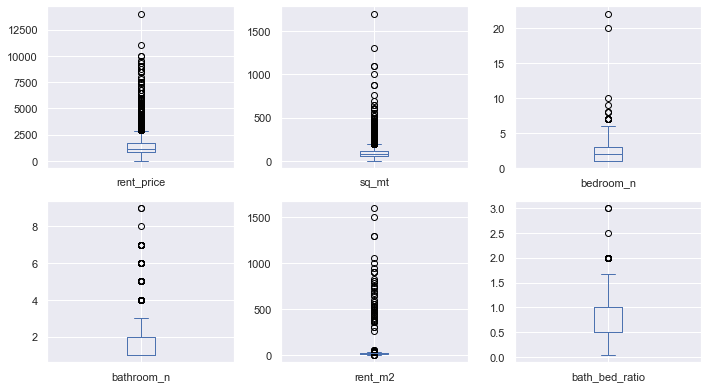

In [1040]:
# outliers?
df_num.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,8), color="b")
plt.tight_layout()
# plt.savefig("boxplots", dpi=400)
plt.show()

In [1041]:
# lets remove all rents above 6000 eur and see the result
filt4 = (df["rent_price"] > 10000)
filt5 = (df["rent_price"] == df["sq_mt"])
filt6 = (df["bedroom_n"] > 10)
filt7 = (df["bathroom_n"] > 8)
filt8 = (df["bath_bed_ratio"] >= 2)

In [1042]:
df.loc[filt4] = np.nan
df.loc[filt5] = np.nan
df.loc[filt6] = np.nan
df.loc[filt7] = np.nan
# df.loc[filt8]

In [1043]:
df.dropna(how="any", inplace=True)

In [1044]:
df = df.reset_index().drop("index", axis=1)

In [1045]:
# Principal Component Analysis (PCA) identifies the combination of components 
# (directions in the feature space) that account for the most variance in the data.
from sklearn.decomposition import PCA
n_comp=3
X_df = df_num.drop(['rent_price'], axis=1)
X = X_df.values
pca = PCA(n_components=n_comp, svd_solver='full', random_state=0)
X_pca = pca.fit_transform(X)
for i in range(n_comp):
    print(X_df.columns[i])
    print(pca.explained_variance_ratio_[i])

sq_mt
0.570430057360732
bedroom_n
0.4294674379796528
bathroom_n
7.362410787796424e-05


In [1046]:
# Our data is positively skewed, which can impact negatively the predict powers of our model
print("Skewness")
for i in df_num.columns:
    print("{}:".format(i), df[i].skew()) 

Skewness
rent_price: 3.15415113868275
sq_mt: 4.49182290317642
bedroom_n: 1.087019401728086
bathroom_n: 2.336566986020104
rent_m2: 11.979930064908794
bath_bed_ratio: 0.8005586858011893


In [1047]:
# In this project we wil try log transformation, sqrt and boxcox. 
# We could however standarize the data using feature scaling which will bring a normal dirtribution of the data
from scipy import stats
from scipy.special import boxcox, inv_boxcox

print("Skewness")

for i in df_num.columns:
    print("{} log transformed:".format(i), np.log(df[i]).skew())
    
print("====================================================")

for i in df_num.columns:
    print("{} sqrt transformed:".format(i), np.sqrt(df[i]).skew())
    
print("====================================================")

for i in df_num.columns:
    print("{} boxcox transformed:".format(i), boxcox(df[i],0).skew())

Skewness
rent_price log transformed: 0.6307087945717019
sq_mt log transformed: -1.5458165472014305
bedroom_n log transformed: 0.05638714621809204
bathroom_n log transformed: 1.0769754576833497
rent_m2 log transformed: 4.16537965299119
bath_bed_ratio log transformed: -0.44760321013334686
rent_price sqrt transformed: 1.8065952712063063
sq_mt sqrt transformed: 1.5914716973525485
bedroom_n sqrt transformed: 0.4821882478959281
bathroom_n sqrt transformed: 1.5598857282459688
rent_m2 sqrt transformed: 9.022983724761746
bath_bed_ratio sqrt transformed: 0.06361573798818812
rent_price boxcox transformed: 0.6307087945717019
sq_mt boxcox transformed: -1.5458165472014305
bedroom_n boxcox transformed: 0.05638714621809204
bathroom_n boxcox transformed: 1.0769754576833497
rent_m2 boxcox transformed: 4.16537965299119
bath_bed_ratio boxcox transformed: -0.44760321013334686


In [1048]:
df_num_log = pd.DataFrame()
df_num_sqrt = pd.DataFrame()
df_num_boxcox = pd.DataFrame()

In [1049]:
for i in df_num.columns:
    df_num_log[i] = np.log(df[i])
    
for i in df_num.columns:
    df_num_sqrt[i] = np.sqrt(df[i])
    
for i in df_num.columns:
    df_num_boxcox[i] = boxcox(df[i],0)

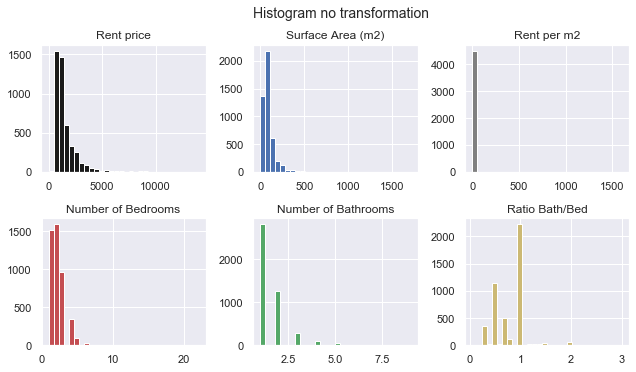

In [1050]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,5))

ax1.hist(df_num["rent_price"],color="k", bins=30)
ax1.set_title("Rent price")
ax2.hist(df_num["sq_mt"],color="b", bins=30)
ax2.set_title("Surface Area (m2)")
ax3.hist(df_num["rent_m2"],color="grey", bins=30)
ax3.set_title("Rent per m2")
ax4.hist(df_num["bedroom_n"],color="r", bins=30)
ax4.set_title("Number of Bedrooms")
ax5.hist(df_num["bathroom_n"],color="g", bins=30)
ax5.set_title("Number of Bathrooms")
ax6.hist(df_num["bath_bed_ratio"],color="y", bins=30)
ax6.set_title("Ratio Bath/Bed")
fig.text(0.4, 1,"Histogram no transformation", fontsize=14)
plt.tight_layout()
# plt.savefig("hist_no_transformation.png", dpi=400)
plt.show()

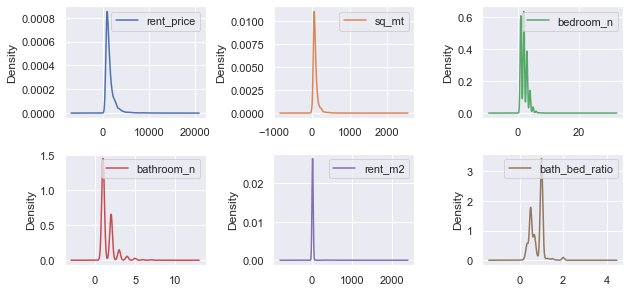

In [1051]:
# Density plots are another way of getting a quick idea of the distribution of each attribute.
df_num.plot(kind='density', subplots=True, layout=(3,3), sharex=False,figsize=(9,6))
plt.tight_layout()
# plt.savefig("densityplot.png", dpi=400)
plt.show()

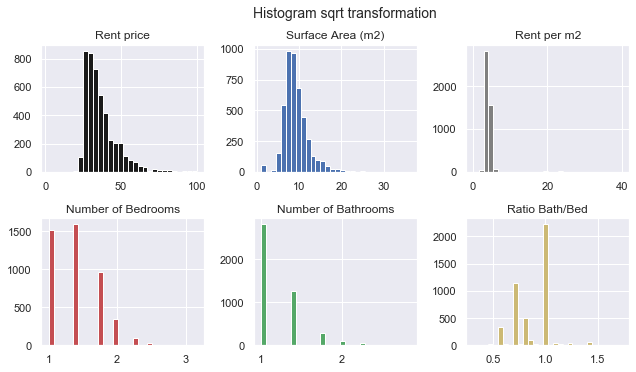

In [1052]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,5))

ax1.hist(df_num_sqrt["rent_price"],color="k", bins=30)
ax1.set_title("Rent price")
ax2.hist(df_num_sqrt["sq_mt"],color="b", bins=30)
ax2.set_title("Surface Area (m2)")
ax3.hist(df_num_sqrt["rent_m2"],color="grey", bins=30)
ax3.set_title("Rent per m2")
ax4.hist(df_num_sqrt["bedroom_n"],color="r", bins=30)
ax4.set_title("Number of Bedrooms")
ax5.hist(df_num_sqrt["bathroom_n"],color="g", bins=30)
ax5.set_title("Number of Bathrooms")
ax6.hist(df_num_sqrt["bath_bed_ratio"],color="y", bins=30)
ax6.set_title("Ratio Bath/Bed")
fig.text(0.4, 1,"Histogram sqrt transformation", fontsize=14)
plt.tight_layout()
# plt.savefig("hist_sqrt_transformation.png", dpi=400)
plt.show()

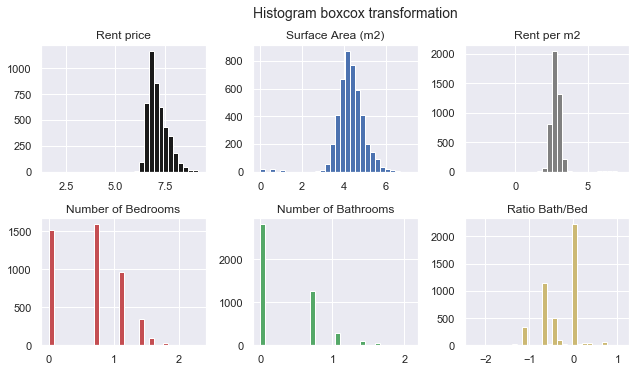

In [1053]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,5))

ax1.hist(df_num_boxcox["rent_price"],color="k", bins=30)
ax1.set_title("Rent price")
ax2.hist(df_num_boxcox["sq_mt"],color="b", bins=30)
ax2.set_title("Surface Area (m2)")
ax3.hist(df_num_boxcox["rent_m2"],color="grey", bins=30)
ax3.set_title("Rent per m2")
ax4.hist(df_num_boxcox["bedroom_n"],color="r", bins=30)
ax4.set_title("Number of Bedrooms")
ax5.hist(df_num_boxcox["bathroom_n"],color="g", bins=30)
ax5.set_title("Number of Bathrooms")
ax6.hist(df_num_boxcox["bath_bed_ratio"],color="y", bins=30)
ax6.set_title("Ratio Bath/Bed")

fig.text(0.4, 1,"Histogram boxcox transformation", fontsize=14)
plt.tight_layout()
# plt.savefig("hist_boxcox.png", dpi=400)
plt.show()

In [1054]:
 # we can also use df.transform()
# df_log = df.transform(func=["log"])

In [1055]:
# Hence the best option is to boxcot transform our data

In [1056]:
df_num_boxcox[["specific_location", "area_madrid"]] = df[["specific_location", "area_madrid"]]

In [1057]:
df_boxcox = df_num_boxcox

In [1058]:
df_num_boxcox.isna().sum()

rent_price           0
sq_mt                0
bedroom_n            0
bathroom_n           0
rent_m2              0
bath_bed_ratio       0
specific_location    0
area_madrid          0
dtype: int64

In [1059]:
# transformmed df
df_boxcox

,rent_price,sq_mt,bedroom_n,bathroom_n,rent_m2,bath_bed_ratio,specific_location,area_madrid
0,6.620073,4.248495,1.098612,0.000000,2.371578,-1.098612,San Andrés,Villaverde
1,6.684612,3.828641,0.000000,0.000000,2.855970,0.000000,Prosperidad,Chamartín
2,7.600902,4.812184,1.098612,0.693147,2.788718,-0.405465,Argüelles,Moncloa-Aravaca
3,7.377759,4.905275,1.098612,0.693147,2.472484,-0.405465,La Paz,Fuencarral-El Pardo
4,6.684612,4.007333,0.000000,0.000000,2.677279,0.000000,Delicias,Arganzuela
...,...,...,...,...,...,...,...,...
4553,7.495542,4.700480,0.693147,0.693147,2.795062,0.000000,Jerónimos,Retiro
4554,6.882437,4.094345,0.693147,0.000000,2.788093,-0.693147,Argüelles,Moncloa-Aravaca
4555,7.937375,5.192957,1.386294,0.693147,2.744418,-0.693147,Goya,Salamanca
4556,7.783224,4.276666,0.693147,0.693147,3.506558,0.000000,Goya,Salamanca


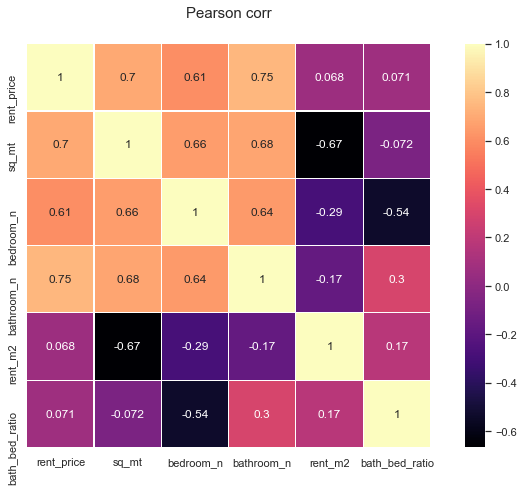

In [1060]:
colormap=plt.cm.magma
plt.title("Pearson corr", y=1.05, size=15)
sns.heatmap(df_boxcox.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)
# plt.savefig("corr.png", dpi=400)
plt.tight_layout()
plt.show()

In [1061]:
corr_matrix = df_boxcox.corr()

In [1062]:
corr_matrix["rent_price"].sort_values(ascending=False)

rent_price        1.000000
bathroom_n        0.751842
sq_mt             0.697775
bedroom_n         0.607940
bath_bed_ratio    0.070968
rent_m2           0.068073
Name: rent_price, dtype: float64

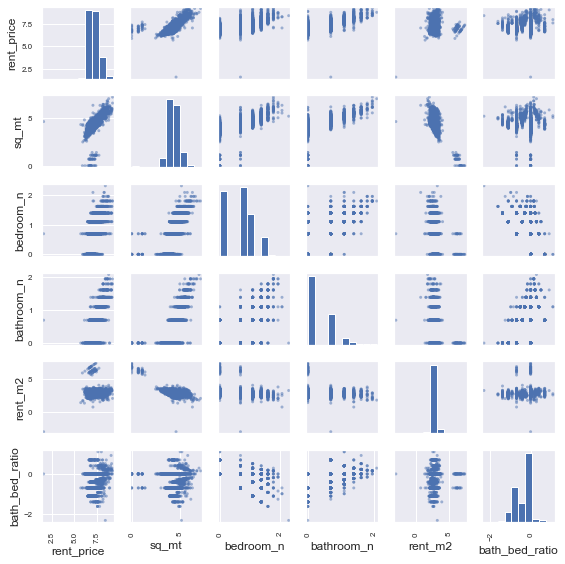

In [1063]:
# Scatter plots are useful for spotting structured relationships between variables,
pd.plotting.scatter_matrix(df_boxcox, figsize=(8,8), color="b")
plt.tight_layout()
# plt.savefig("scatter_matrix.png", dpi=400)
plt.show()

In [1064]:
pivot_price_area = pd.pivot_table(df, index=["area_madrid"], values=["rent_price"], aggfunc="mean").sort_values(by="area_madrid").reset_index()

In [1065]:
pivot_area_sem =pd.pivot_table(df, index=["area_madrid"], values=["rent_price"], aggfunc="sem").sort_values(by="area_madrid").reset_index()

In [1066]:
pivot_price_area["sem"] = pivot_area_sem["rent_price"]

In [1067]:
pivot_price_area.sort_values(by="rent_price", ascending=False, inplace=True)

In [1068]:
cnames = {
'aliceblue':            '#F0F8FF',
'antiquewhite':         '#FAEBD7',
'aqua':                 '#00FFFF',
'aquamarine':           '#7FFFD4',
'azure':                '#F0FFFF',
'beige':                '#F5F5DC',
'bisque':               '#FFE4C4',
'black':                '#000000',
'blanchedalmond':       '#FFEBCD',
'blue':                 '#0000FF',
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chartreuse':           '#7FFF00',
'chocolate':            '#D2691E',
'coral':                '#FF7F50',
'cornflowerblue':       '#6495ED',
'cornsilk':             '#FFF8DC',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkgoldenrod':        '#B8860B',
'darkgray':             '#A9A9A9',
'darkgreen':            '#006400',
'darkkhaki':            '#BDB76B',
'darkmagenta':          '#8B008B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darkorchid':           '#9932CC',
'darkred':              '#8B0000',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'goldenrod':            '#DAA520',
'gray':                 '#808080',
'green':                '#008000',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'lavender':             '#E6E6FA',
'lavenderblush':        '#FFF0F5',
'lawngreen':            '#7CFC00',
'lemonchiffon':         '#FFFACD',
'lightblue':            '#ADD8E6',
'lightcoral':           '#F08080',
'lightcyan':            '#E0FFFF',
'lightgoldenrodyellow': '#FAFAD2',
'lightgreen':           '#90EE90',
'lightgray':            '#D3D3D3',
'lightpink':            '#FFB6C1',
'lightsalmon':          '#FFA07A',
'lightseagreen':        '#20B2AA',
'lightskyblue':         '#87CEFA',
'lightslategray':       '#778899',
'lightsteelblue':       '#B0C4DE',
'lightyellow':          '#FFFFE0',
'lime':                 '#00FF00',
'limegreen':            '#32CD32',
'linen':                '#FAF0E6',
'magenta':              '#FF00FF',
'maroon':               '#800000',
'mediumaquamarine':     '#66CDAA',
'mediumblue':           '#0000CD',
'mediumorchid':         '#BA55D3',
'mediumpurple':         '#9370DB',
'mediumseagreen':       '#3CB371',
'mediumslateblue':      '#7B68EE',
'mediumspringgreen':    '#00FA9A',
'mediumturquoise':      '#48D1CC',
'mediumvioletred':      '#C71585',
'midnightblue':         '#191970',
'mintcream':            '#F5FFFA',
'mistyrose':            '#FFE4E1',
'moccasin':             '#FFE4B5',
'navajowhite':          '#FFDEAD',
'navy':                 '#000080',
'oldlace':              '#FDF5E6',
'olive':                '#808000',
'olivedrab':            '#6B8E23',
'orange':               '#FFA500',
'orangered':            '#FF4500',
'orchid':               '#DA70D6',
'palegoldenrod':        '#EEE8AA',
'palegreen':            '#98FB98',
'paleturquoise':        '#AFEEEE',
'palevioletred':        '#DB7093',
'papayawhip':           '#FFEFD5',
'peachpuff':            '#FFDAB9',
'peru':                 '#CD853F',
'pink':                 '#FFC0CB',
'plum':                 '#DDA0DD',
'powderblue':           '#B0E0E6',
'purple':               '#800080',
'red':                  '#FF0000',
'rosybrown':            '#BC8F8F',
'royalblue':            '#4169E1',
'saddlebrown':          '#8B4513',
'salmon':               '#FA8072',
'sandybrown':           '#FAA460',
'seagreen':             '#2E8B57',
'seashell':             '#FFF5EE',
'sienna':               '#A0522D',
'silver':               '#C0C0C0',
'skyblue':              '#87CEEB',
'slateblue':            '#6A5ACD',
'slategray':            '#708090',
'snow':                 '#FFFAFA',
'springgreen':          '#00FF7F',
'steelblue':            '#4682B4',
'tan':                  '#D2B48C',
'teal':                 '#008080',
'thistle':              '#D8BFD8',
'tomato':               '#FF6347',
'turquoise':            '#40E0D0',
'violet':               '#EE82EE',
'wheat':                '#F5DEB3',
'white':                '#FFFFFF',
'whitesmoke':           '#F5F5F5',
'yellow':               '#FFFF00',
'yellowgreen':          '#9ACD32'}

In [1069]:
list_colors = list(cnames.values())

In [1070]:
#generating a random  list of colors
random_color_list = list(pd.Series(list_colors).sample(21))

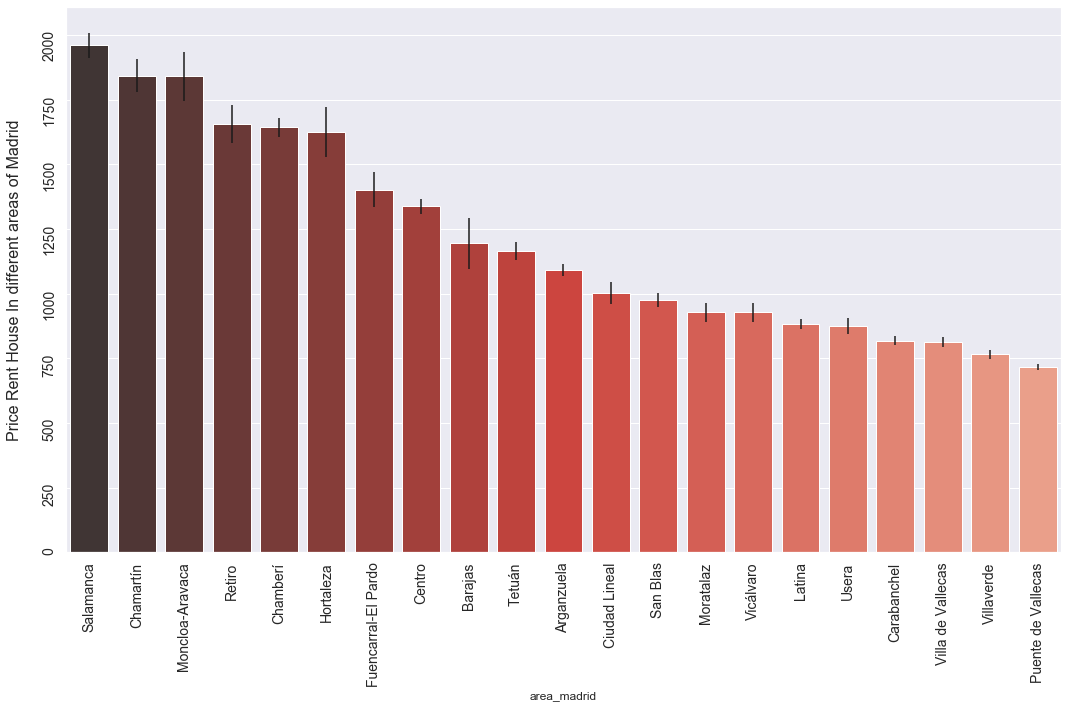

In [1071]:
plt.rcParams["figure.figsize"] = (15,10)
sns.barplot(x=pivot_price_area["area_madrid"],y=pivot_price_area["rent_price"], data=pivot_price_area, yerr=pivot_price_area["sem"], palette="Reds_d")
plt.ylabel("Price Rent House In different areas of Madrid", fontsize=16, labelpad=20)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=90, fontsize=14)
plt.tight_layout()
# plt.savefig("area_rent_price.png", dpi=400)
plt.show()

In [1072]:
pivot_count_loc = pd.pivot_table(df, index=["specific_location"], values=["rent_price"], aggfunc="count").\
sort_values(by="specific_location").reset_index()

In [1073]:
pivot_count_loc.loc[pivot_count_loc["rent_price"]==1] = np.nan

In [1074]:
pivot_count_loc.rename({"rent_price":"count"}, axis=1, inplace=True)

In [1075]:
pivot_price_loc = pd.pivot_table(df, index=["specific_location"], values=["rent_price"], aggfunc="mean").\
sort_values(by="specific_location").reset_index()

In [1076]:
pivot_price_loc["count"] = pivot_count_loc["count"]

In [1077]:
pivot_price_loc.dropna(how="any", inplace=True)

In [1078]:
pivot_price_loc.reset_index().drop("index", axis=1, inplace=True)

In [1079]:
pivot_price_loc.shape

(131, 3)

In [1080]:
pivot_loc_sem =pd.pivot_table(df, index=["specific_location"], values=["rent_price"], aggfunc="sem").\
sort_values(by="specific_location").reset_index()

In [1081]:
pivot_loc_sem.rename({"rent_price":"sem"}, axis=1, inplace=True)

In [1082]:
sem = (list(pivot_loc_sem["sem"])) # !

In [1083]:
pivot_price_loc.dropna(how="any", inplace=True)

In [1084]:
pivot_price_loc.reset_index().drop("index", axis=1, inplace=True)

In [1085]:
pivot_price_loc.reset_index()

,index,specific_location,rent_price,count
0,0,Abrantes,855.714286,14.0
1,1,Acacias,1125.961538,52.0
2,2,Adelfas,1411.447368,38.0
3,3,Aeropuerto,2395.000000,5.0
4,4,Alameda de Osuna,1683.333333,6.0
...,...,...,...,...
126,129,Ventas,857.187500,32.0
127,130,Vinateros,942.222222,9.0
128,131,Virgen del Cortijo-Manoteras,1092.500000,10.0
129,132,Vista Alegre,778.260870,23.0


In [1086]:
pivot_price_loc["sem"] = sem

In [1087]:
# pivot_loc_sem.rename({"specific_location":"loc"}, axis=1, inplace=True)

In [1088]:
pivot_price_loc.sort_values("rent_price", ascending=False, inplace=True)

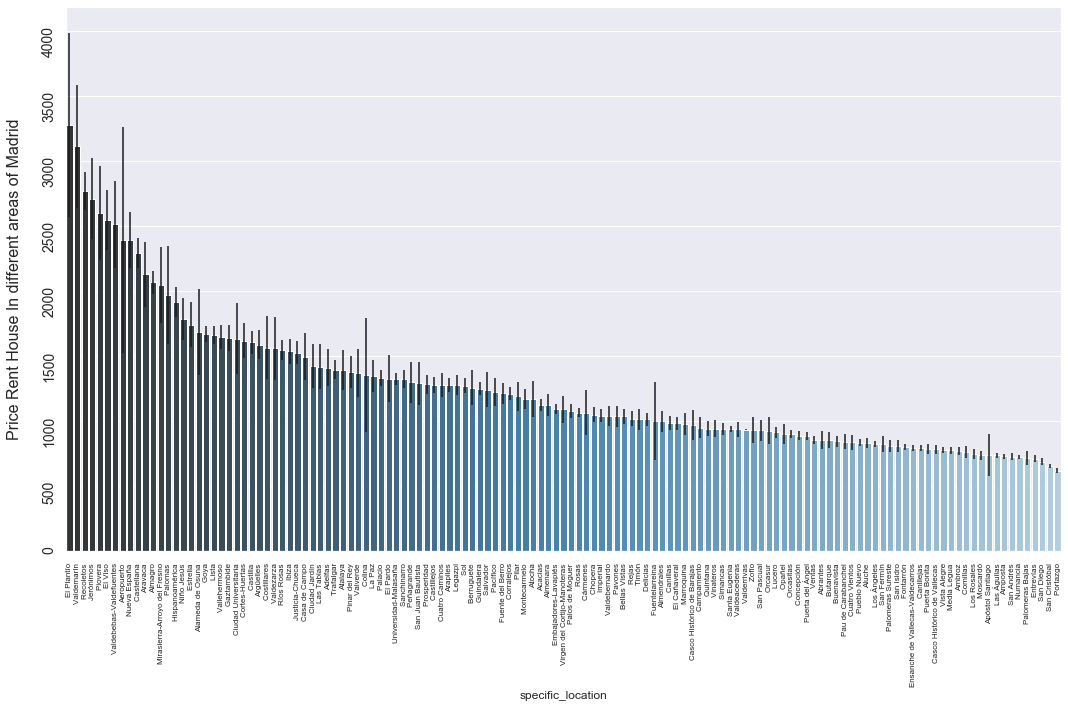

In [1089]:
plt.rcParams["figure.figsize"] = (15,10)
sns.barplot(x=pivot_price_loc["specific_location"],y=pivot_price_loc["rent_price"], data=pivot_price_loc, yerr=pivot_price_loc["sem"],  palette="Blues_d")
plt.ylabel("Price Rent House In different areas of Madrid", fontsize=16, labelpad=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=90, fontsize=14)
plt.tight_layout()
# plt.savefig("location_rent_price.png", dpi=400)
plt.show()

# 3. Data Preprocessing

In [1090]:
# 1. Select attributes
df_model = df_boxcox.loc[:,["rent_price", "sq_mt", "bedroom_n", "bathroom_n", "bath_bed_ratio", "area_madrid"]]

In [1091]:
# 2. Get dummy data
df_model = pd.get_dummies(df_model) # here we could use onehotencoder. See the difference below

OneHotEncoder cannot process string values directly. If your nominal features are strings, then you need to first map them into **integers** (for this we can use the pandas factorize() method).

pandas.get_dummies is kind of the opposite. By default, it only converts **string** columns into one-hot representation, unless columns are specified.

In [1092]:
df_model.columns = df_model.columns.str.replace("area_madrid_", "")

In [1093]:
# 3.1) 
    # Re-scaling data: When your data is comprised of attributes with varying scales, 
    # many machine learning algorithmscan benefit from rescaling the attributes to all have the same scale.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X) # use MinMaxScaler to revert the re-scaled data

In [1094]:
rescaledX # 

array([[0.04061212, 0.0952381 , 0.        , 0.00666569, 0.0974359 ],
       [0.02648617, 0.        , 0.        , 0.01083896, 0.32307692],
       [0.07180695, 0.0952381 , 0.125     , 0.01013197, 0.21025641],
       ...,
       [0.10535609, 0.14285714, 0.125     , 0.00969158, 0.15384615],
       [0.04178929, 0.04761905, 0.125     , 0.02080304, 0.32307692],
       [0.08181283, 0.04761905, 0.125     , 0.01157656, 0.32307692]])

In [1095]:
# 3.2) 
    # Standarized data: It is most suitable for techniques that assume a Gaussian
    # distribution in the input variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
standarizedX = scaler.transform(X)

In [1096]:
standarizedX

array([[-0.29813846,  0.72747628, -0.6127942 , -0.1780724 , -1.51731254],
       [-0.59966482, -0.97775054, -0.6127942 , -0.09003553,  0.66777703],
       [ 0.36773226,  0.72747628,  0.47866328, -0.1049497 , -0.42476776],
       ...,
       [ 1.08385737,  1.58008969,  0.47866328, -0.11423999, -0.97104015],
       [-0.27301126, -0.12513713,  0.47866328,  0.12016103,  0.66777703],
       [ 0.58131343, -0.12513713,  0.47866328, -0.07447553,  0.66777703]])

In [1097]:
# 3.3) Normalize data: This pre-processing method
#      can be useful for sparse datasets (lots of zeros) with attributes of varying scales when using
#      algorithms that weight input values such as neural networks and algorithms that use distance
#      measures such as k-Nearest Neighbors.

from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(X)
normalizedX = scaler.transform(X)

In [1098]:
normalizedX 

array([[0.987493  , 0.04232113, 0.01410704, 0.15114689, 0.00470235],
       [0.93480152, 0.02032177, 0.02032177, 0.35342212, 0.02032177],
       [0.99094229, 0.02416932, 0.01611288, 0.13099905, 0.00537096],
       ...,
       [0.99597771, 0.02213284, 0.01106642, 0.08607215, 0.0027666 ],
       [0.90681891, 0.02518941, 0.02518941, 0.41982357, 0.01259471],
       [0.99109244, 0.01415846, 0.01415846, 0.13147145, 0.00707923]])

The benefits of the above preprocessing techiques were not apparent in our work case probably because we previosly transformed our data

# 4. Model selection and tuning

**Main Aspects to consider before building our model**
1) **Linearity**: assumes that the relationship between predictors and target variable is linear

2) **No noise**: eg. that there are no outliers in the data

3) **No collinearity**: if you have highly correlated predictors, it’s most likely your model will overfit

4) **Normal distribution**: more reliable predictions are made if the predictors and the target variable are normally distributed. Read [Here](https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45)

5) **Scale**: it’s a distance-based algorithm, so preditors should be scaled — like with standard scaler

In [1099]:
from sklearn.model_selection import train_test_split
X = df_model.drop("rent_price", axis=1)
y = df_model["rent_price"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

We will stratify the data based on the sq_m2 since is the attribute that correlates best with the house rental price

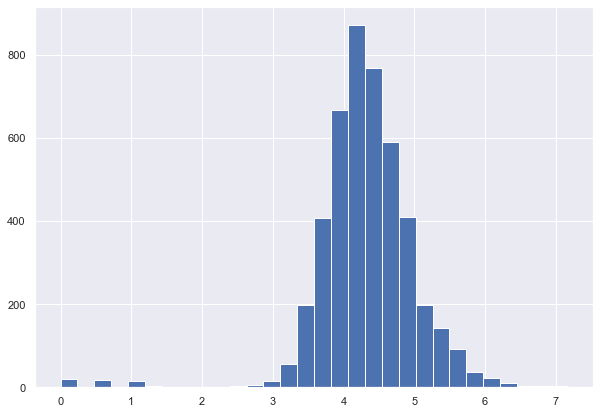

In [1100]:
plt.rcParams["figure.figsize"] = (10,7)
plt.hist(df_model["sq_mt"],color="b", bins=30)
plt.show()

In [1101]:
def strater (col_item):
    if col_item <= 3.5:
        return 1
    elif col_item > 3.5 and col_item <= 4:
        return 2
    elif col_item > 4 and col_item <= 4.5:
        return 3
    elif col_item > 4.5 and col_item <= 5.5:
        return 4
    else:
        return 5

In [1102]:
df_model["strat"] = df_model["sq_mt"].apply(strater)

In [1103]:
test_set = X_test

In [1104]:
test_set["strat"] = X_test["sq_mt"].apply(strater)

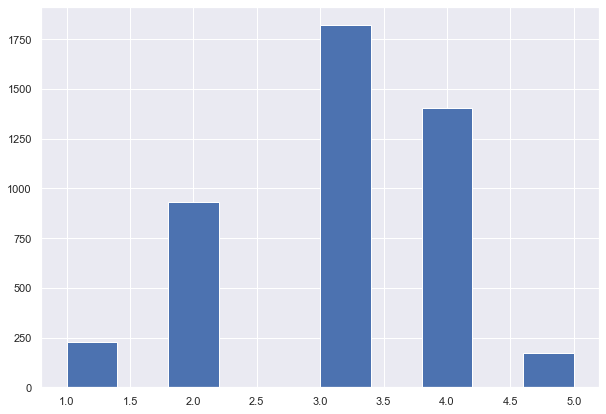

In [1105]:
df_model["strat"].hist()

In [1106]:
from sklearn.model_selection import StratifiedShuffleSplit

In [1107]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=10)

In [1108]:
for train_index, test_index in split.split(df_model, df_model["strat"]):
    strat_train_set = df_model.loc[train_index]
    strat_test_set = df_model.loc[test_index]

In [1109]:
def proportions(data):
    return data["strat"].value_counts()/len(data)

In [1110]:
comparing = pd.DataFrame({"Overall": proportions(df_model),
                         "Stratified": proportions(strat_test_set),
                         "Random": proportions(test_set)}).sort_index()

In [1111]:
comparing = comparing *100 

In [1112]:
comparing 
# We can observe how the proportions in the stratified set are closer 
# to those in the whole set compared to the ramdomly generated set

,Overall,Stratified,Random
1,5.046073,5.043860,5.921053
2,20.447565,20.394737,19.407895
3,39.973673,40.021930,40.021930
4,30.759105,30.811404,31.359649
5,3.773585,3.728070,3.289474


In [1113]:
strat_train_set.drop("strat", axis=1, inplace=True)
strat_test_set.drop("strat", axis=1, inplace=True)

In [1114]:
X_train = strat_train_set.drop("rent_price", axis=1)
y_train = strat_train_set["rent_price"].values

In [1115]:
X_test = strat_test_set.drop("rent_price", axis=1)
y_test = strat_test_set["rent_price"].values

In [1116]:
df_model.drop("strat", axis=1, inplace=True)

In [1117]:
X = df_model.drop("rent_price", axis=1)

In [1118]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit 

import warnings
warnings.filterwarnings("ignore")

In [1119]:
y_train

array([6.90775528, 6.80239476, 7.34601021, ..., 6.99850964, 7.04751722,
       7.09007684])

In [1120]:
# 3. Exploring model performance
models = []
models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso())) 
models.append(('CART', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('NB', GaussianNB()))
models.append(('SVR', SVR()))

results_model = []
names_model = []
for name, model in models:
    KF = KFold(n_splits=10, random_state=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=KF, scoring='neg_mean_absolute_error')
    results_model.append(cv_results)
    names_model.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: -0.194305 (0.011525)
Lasso: -0.408581 (0.006166)
CART: -0.192713 (0.010791)
RFR: -0.169635 (0.008766)
KNN: -0.170437 (0.007205)
NB: nan (nan)
SVR: -0.156041 (0.010664)


In [1121]:
# SVR seems to be performing best

In [1122]:
kernel = ["rbf"] # ["linear", "poly", "rbf", "sigmoid"] 
C = [0.1, 0.5, 1.0, 1.3, 1.5, 1.8, 2.1]

param_grid = dict(kernel=kernel, C=C)


model = SVR()
KF = KFold(n_splits=5, random_state=10) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_mean_absolute_error", cv=KF)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # Best -0.161017 using {'C': 2.1, 'kernel': 'rbf'}

Best: -0.155519 using {'C': 2.1, 'kernel': 'rbf'}
-0.162643 (0.002651) with: {'C': 0.1, 'kernel': 'rbf'}
-0.157763 (0.002970) with: {'C': 0.5, 'kernel': 'rbf'}
-0.156607 (0.003227) with: {'C': 1.0, 'kernel': 'rbf'}
-0.156110 (0.003138) with: {'C': 1.3, 'kernel': 'rbf'}
-0.155911 (0.003127) with: {'C': 1.5, 'kernel': 'rbf'}
-0.155695 (0.003087) with: {'C': 1.8, 'kernel': 'rbf'}
-0.155519 (0.003142) with: {'C': 2.1, 'kernel': 'rbf'}


In [1123]:
# 5 test
SVR = SVR(kernel="rbf", C=1.8)
SVR.fit(X_train, y_train)

SVR(C=1.8, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [1124]:
SVR_pred = SVR.predict(X_test)
SVR_pred= SVR_pred.reshape(-1,1)

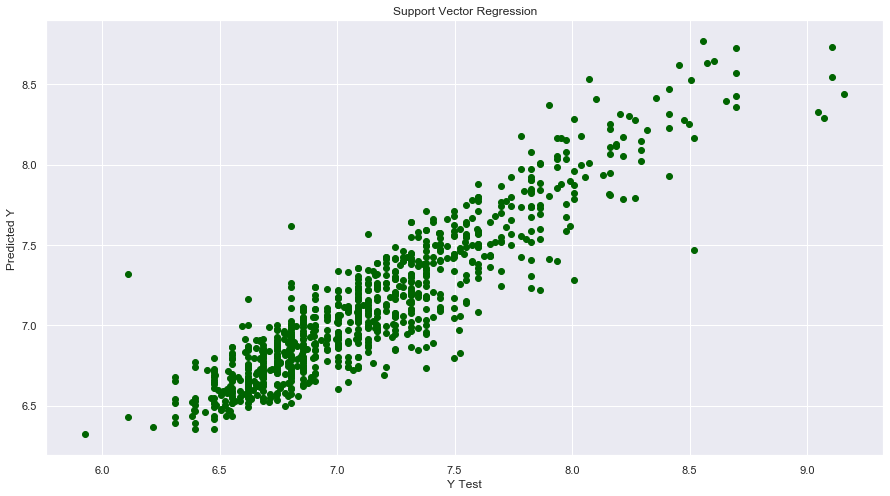

In [1125]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,SVR_pred,c='darkgreen')
plt.title("Support Vector Regression")
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.savefig("SVR.png", dpi=400)
plt.show()

In [1126]:
SVR.score(X_test,y_test)

0.8411292076897467

In [1127]:
from scipy.special import boxcox, inv_boxcox

def predict_price(area, sq_mt, bedrooms, bathrooms):
    loc_index = np.where(X.columns==area)[0][0] # X is an np array so we use where method to loc the index
    
    x= np.zeros(len(X.columns))
    x[0] = boxcox(sq_mt,0)
    x[1] = boxcox(bedrooms,0)
    x[2] = boxcox(bathrooms,0)
    if loc_index >= 0:
        x[loc_index] = 1
    print(x)
        
    return inv_boxcox(SVR.predict([x])[0],0)


In [1128]:
predict_price('San Blas',260,4,4)

[5.56068163 1.38629436 1.38629436 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.        ]


2520.2418226320715

# 5. Productionazing the model

In [1129]:
import pickle
with open ("Madrid_rent_price.pickle", "wb") as f:
    pickle.dump(SVR,f)

In [1130]:
import json
columns = {"data_columns":[col.lower() for col in X.columns]}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))